In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CNCnoise_1.csv to CNCnoise_1.csv


In [ ]:
data = pd.read_csv("CNCnoise_1.csv", header=None)
data.columns = ['noise']

In [ ]:
# === 파라미터 설정 영역 ===
look_back = 50  # 시계열 길이
knn_neighbors = 7  # K-NN 이웃 수
knn_percentile = 98  # 이상치 임계값 퍼센타일
lr_percentile = 95  # 회귀 기반 잔차 임계값 퍼센타일
rolling_window_size = 2000  # 이동 평균 윈도우 크기
rolling_k = 3.0  # ±kσ 경계

In [ ]:
# === 윈도우 기반 시계열 구성 ===
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back)].values.flatten()
        target = data[i + look_back]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_dataset(data['noise'], look_back)
noise_full = data['noise'].values[look_back:]

In [ ]:
# === Rolling Mean ± kσ 계산 (시각적 기준선용) ===
rolling_mean = pd.Series(noise_full).rolling(window=rolling_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=rolling_window_size, center=True).std()
upper_bound = rolling_mean + rolling_k * rolling_std
lower_bound = rolling_mean - rolling_k * rolling_std

In [ ]:
# 1. K-NN 이상치 탐지 (앞부분 일부만)
sample_size = 60000
X_sampled = X[:sample_size]
noise_sampled = noise_full[:sample_size]

knn = NearestNeighbors(n_neighbors=knn_neighbors)
knn.fit(X_sampled)
distances, _ = knn.kneighbors(X_sampled)
avg_distances = distances.mean(axis=1)
threshold_knn = np.percentile(avg_distances, knn_percentile)
is_outlier_knn = avg_distances > threshold_knn

In [ ]:
# === 2. Linear Regression 이상치 탐지 ===
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = np.abs(y - y_pred)
threshold_lr = np.percentile(residuals, lr_percentile)
is_outlier_lr = residuals > threshold_lr

In [ ]:
# 3. 시각화

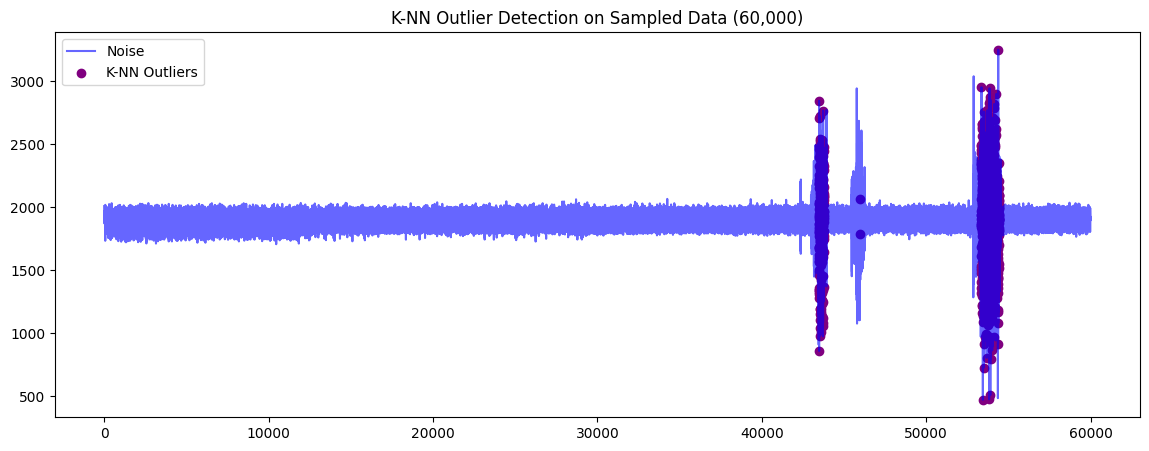

In [ ]:
# === 시각화: K-NN ===
plt.figure(figsize=(14, 5))
plt.plot(noise_sampled, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.where(is_outlier_knn)[0], noise_sampled[is_outlier_knn], color='purple', label='K-NN Outliers')
plt.title("K-NN Outlier Detection on Sampled Data (60,000)")
plt.legend()
plt.show()


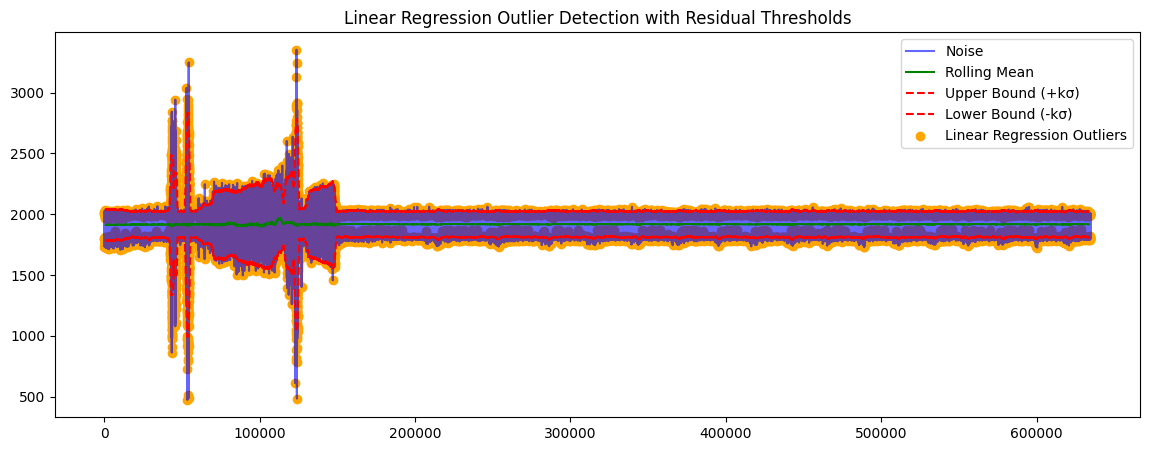

In [ ]:
# === 시각화: Linear Regression ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (+kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (-kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_lr)[0], noise_full[is_outlier_lr], color='orange', label='Linear Regression Outliers')
plt.title("Linear Regression Outlier Detection with Residual Thresholds")
plt.legend()
plt.show()


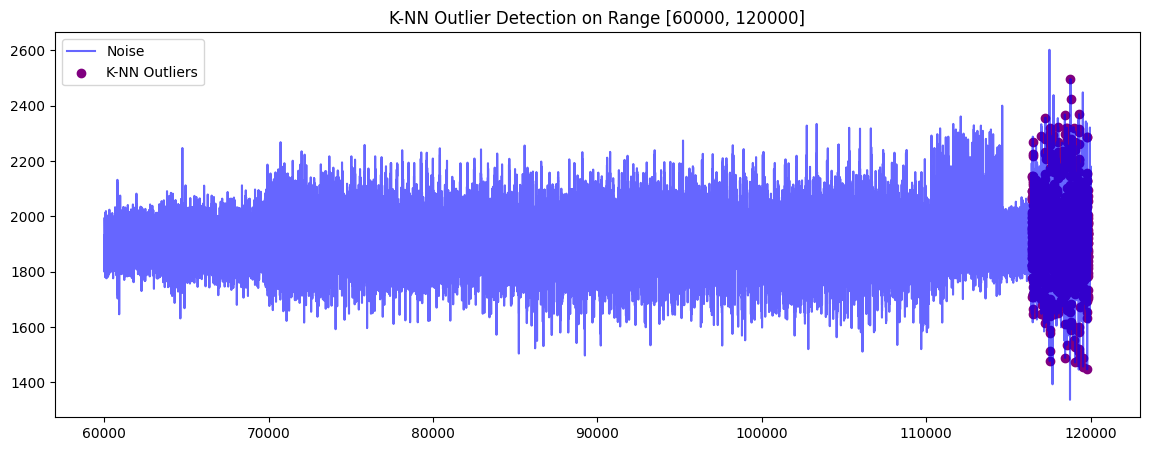

In [ ]:
# === 1-2. K-NN 이상치 탐지: 구간 확장 ===
start_idx = 60000
end_idx = 120000
X_sampled = X[start_idx:end_idx]
y_sampled = y[start_idx:end_idx]

knn = NearestNeighbors(n_neighbors=knn_neighbors)
knn.fit(X_sampled)
distances, _ = knn.kneighbors(X_sampled)
avg_distances = distances.mean(axis=1)
threshold_knn = np.percentile(avg_distances, knn_percentile)
is_outlier_knn = avg_distances > threshold_knn

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(np.arange(start_idx, end_idx), y_sampled, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.arange(start_idx, end_idx)[is_outlier_knn], y_sampled[is_outlier_knn], color='purple', label='K-NN Outliers')
plt.title("K-NN Outlier Detection on Range [{}, {}]".format(start_idx, end_idx))
plt.legend()
plt.show()

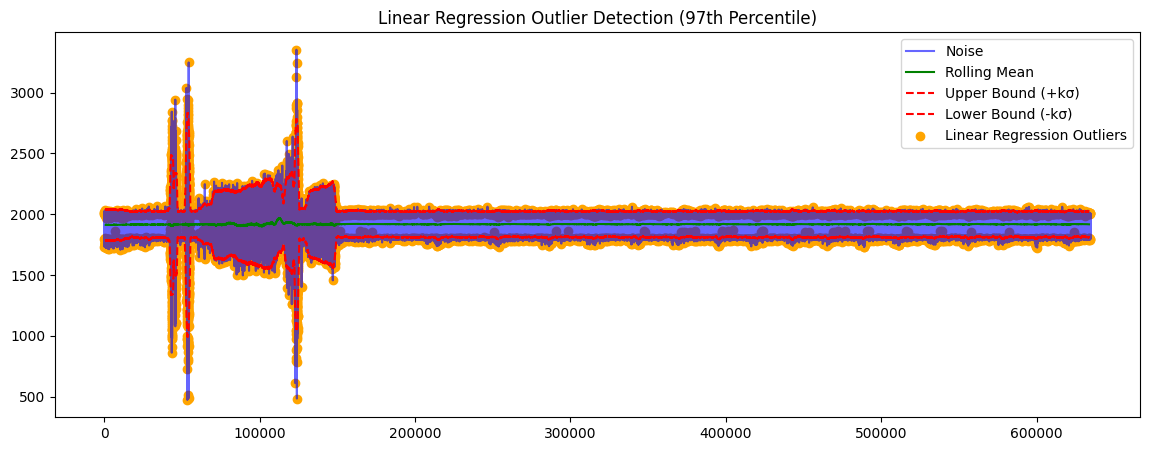

In [ ]:
# === 2. Linear Regression 이상치 탐지 (재조정) ===
lr_percentile = 97  # 민감도 완화
threshold_lr = np.percentile(residuals, lr_percentile)
is_outlier_lr = residuals > threshold_lr

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (+kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (-kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_lr)[0], noise_full[is_outlier_lr], color='orange', label='Linear Regression Outliers')
plt.title("Linear Regression Outlier Detection (97th Percentile)")
plt.legend()
plt.show()

In [ ]:
# Linear Regression 조정
lr_percentile = 99
threshold_lr = np.percentile(residuals, lr_percentile)
is_outlier_lr = residuals > threshold_lr

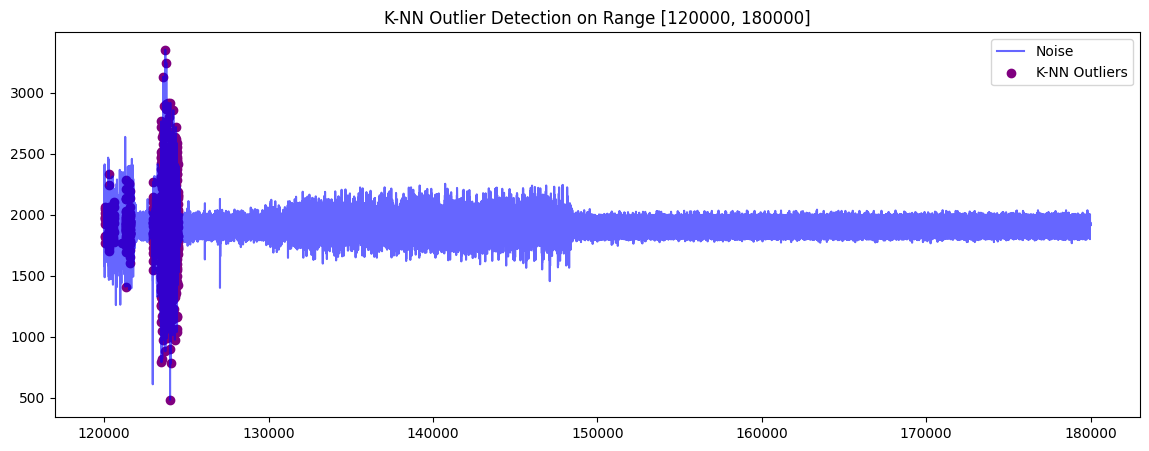

In [ ]:
# === 1-2. K-NN 이상치 탐지: 구간 확장 ===
start_idx = 120000
end_idx = 180000
X_sampled = X[start_idx:end_idx]
y_sampled = y[start_idx:end_idx]

knn = NearestNeighbors(n_neighbors=knn_neighbors)
knn.fit(X_sampled)
distances, _ = knn.kneighbors(X_sampled)
avg_distances = distances.mean(axis=1)
threshold_knn = np.percentile(avg_distances, knn_percentile)
is_outlier_knn = avg_distances > threshold_knn

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(np.arange(start_idx, end_idx), y_sampled, label='Noise', color='blue', alpha=0.6)
plt.scatter(np.arange(start_idx, end_idx)[is_outlier_knn], y_sampled[is_outlier_knn], color='purple', label='K-NN Outliers')
plt.title("K-NN Outlier Detection on Range [{}, {}]".format(start_idx, end_idx))
plt.legend()
plt.show()

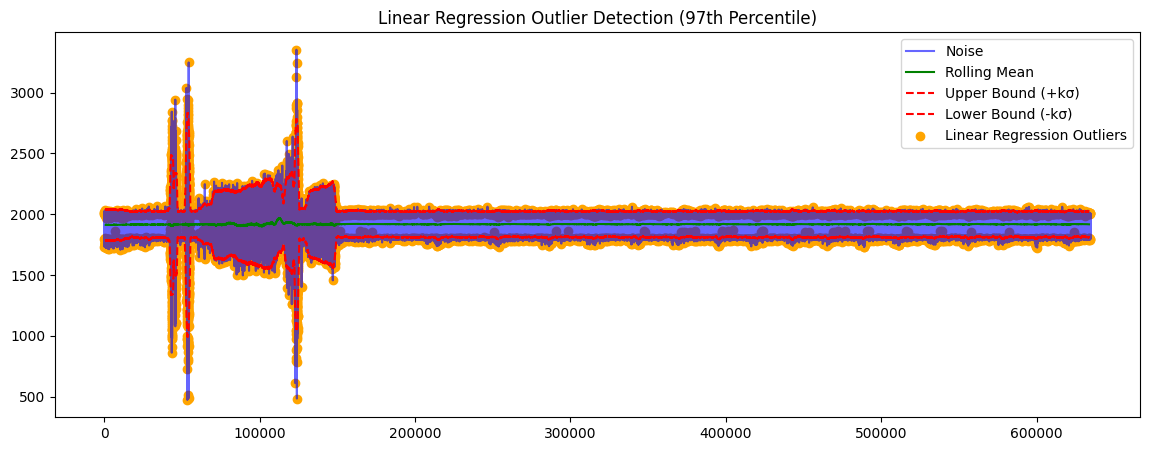

In [ ]:
# === 2. Linear Regression 이상치 탐지 (재조정) ===
lr_percentile = 97  # 민감도 완화
threshold_lr = np.percentile(residuals, lr_percentile)
is_outlier_lr = residuals > threshold_lr

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (+kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (-kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_lr)[0], noise_full[is_outlier_lr], color='orange', label='Linear Regression Outliers')
plt.title("Linear Regression Outlier Detection (97th Percentile)")
plt.legend()
plt.show()

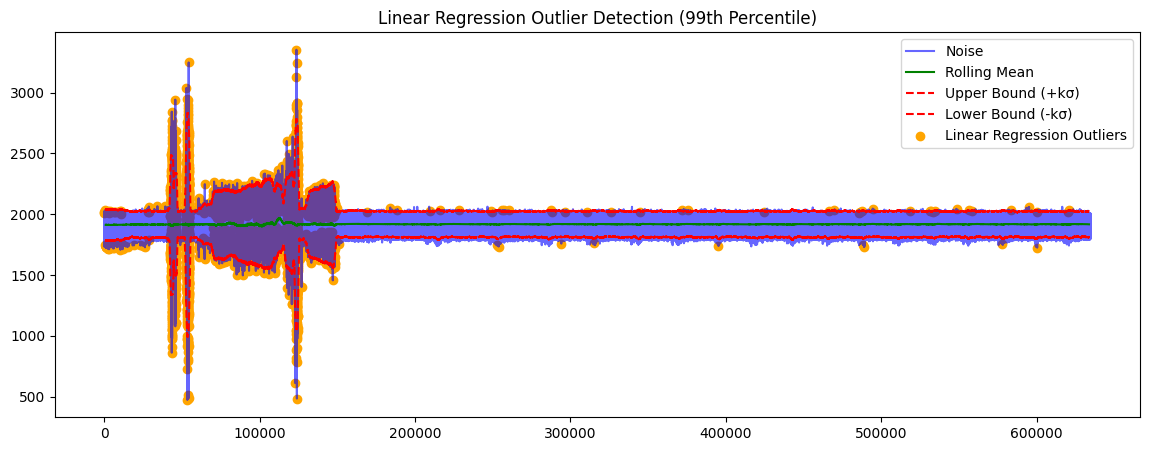

In [ ]:
# Linear Regression 이상치 재조정
lr_percentile = 99
threshold_lr = np.percentile(residuals, lr_percentile)
is_outlier_lr = residuals > threshold_lr

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (+kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (-kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_lr)[0], noise_full[is_outlier_lr], color='orange', label='Linear Regression Outliers')
plt.title("Linear Regression Outlier Detection (99th Percentile)")
plt.legend()
plt.show()